
# Object detection with Faster RCNN

1. RCNN: Bounding box selective search

Image processing techniques are used to make list of proposed regions.
- Takes almost 30 - 40 seconds for inference on a single image
- RCNN is better than sliding window, but still computationally expensive!
- Used SVM at last?
- Separate CNN per region

2. Fast Region proposal(Fast RCNN):
- Bounding boxes still found using selective search
- Removed external classifier called SVM
- Single CNN for entire image
- 2 to 3 seconds

3. Faster RCNN:
- Selective search had problems and was expensive
- CNN Features for bounding box and Region proposals -> Region Proposal Network
- Single CNN for entire image
- 200ms 


Two stage object detections!


### Faster RCNN Resnet 50 model

Input:
- n, c, h, w
- batch size, channels, height, width

Return :
- Bounding boxes [x0, y0, x1, y1], all predicted in the shape of (N,4) where N is the number of classes
- Labels for all predicted classes
- Scores of each predicted label

## Necessary Imports

In [11]:
import torch
import torchvision 
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import subprocess
from PIL import Image
import urllib.request
import glob

In [12]:
np.random.seed(0)

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()


COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

In [20]:
def get_prediction(image_path, threshold):
    img = Image.open(image_path)
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    pred = model([img])
    prediction = pred[0]
    # detach from computational graph
    labels = prediction['labels'].detach().numpy()
    scores = prediction['scores'].detach().numpy()
    boxes = prediction['boxes'].detach().numpy()

    # filter predictions based on threshold
    valid_idx = scores > threshold

    pred_boxes = [((b[0],b[1]),(b[2],b[3])) for b in boxes[valid_idx]]
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_idx]]

    return pred_boxes, pred_classes


In [24]:
def object_detection(img_path, threshold = 0.5):
    boxes, classes = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rect_th = max(round(sum(img.shape)/2 * 0.003), 2)
    text_th = max(rect_th -1, 1)
    for i in range(len(boxes)):
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(classes[i])]
        cv2.rectangle(img, p1, p2, color, rect_th)

        w, h = cv2.getTextSize(classes[i], cv2.FONT_HERSHEY_SIMPLEX, rect_th/3, text_th)[0]
        # decide if the text should be outside or inside the box
        outside = p1[1] - h > 3
        p2 = p1[0] + w, p1[1] - h -3 if outside else p1[1] + h + 3
        cv2.rectangle(img, p1, p2, color, -1)

        cv2.putText(img, classes[i], (p1[0], p1[1]-5 if outside else p1[1] + h +2), cv2.FONT_HERSHEY_SIMPLEX, rect_th/3, (255, 255, 255), text_th + 1)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [25]:
# download test images
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['curl', url, '-o', save_name, '-q'])

inference_dir = "inference_rcnn"
os.makedirs(inference_dir, exist_ok = True)


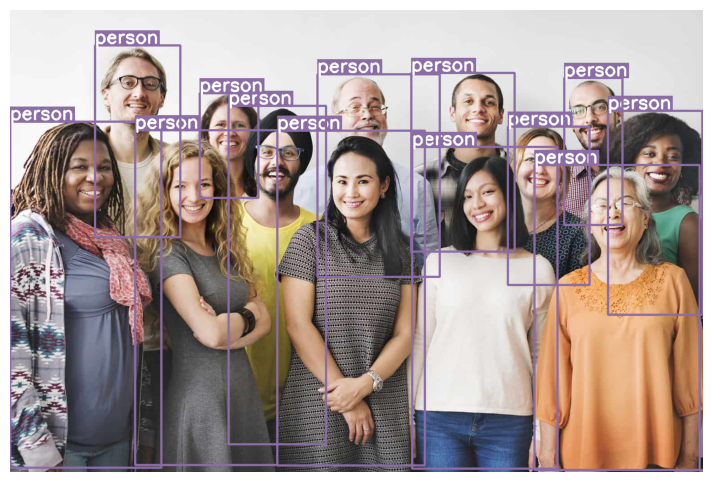

In [27]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/people.jpg',
    os.path.join(inference_dir, 'people.jpg')
)

object_detection(os.path.join(inference_dir, 'people.jpg'), threshold=0.8)